In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:42761'

/home/a/a270042/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'amoc'
which_lat = 26.5 # 'max' # 'max', 26.0
year      = [1958,1972]
mon       = None
day       = None
record    = None 
box       = None
depth     = None
dlat      = 1.0   # binning resolution in deg 
do_bolus  = False

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
do_enum           = False  # do enumeration of panels
save_dpi          = 300
save_fmt          = ['png']
#do_rapid          = False

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
do_ucell          = True   # do time series of upper amoc cell 
do_lcell          = False  # do time series of lower amoc cell 

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem, 
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39909 instead
  warnings.warn(


Started a new Dask client: <Client: 'tcp://127.0.0.1:46561' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/39909/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/39909/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46561,Workers: 32
Dashboard: /user/a270042/levante-spawner-preset//proxy/39909/status,Total threads: 64
Started: Just now,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:33401,Total threads: 2
Dashboard: /user/a270042/levante-spawner-preset//proxy/36941/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:33715,


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, _, _ = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

# #______________________________________________________________________________________________________        
# cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    

# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)
    

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 12    , 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : mesh.nlev-1, 
               'nz'   : mesh.nlev, 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of horizontal chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.08
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 # dive by 4 because we use 4byte single precision
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    chunks['elem'] = chunks['nod2'] = np.int32(np.ceil(chunk_size))
    print(' --> set elem/nod2 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 549.32Mb
 --> set elem/nod2 chunk size to 8.00% of worker mem.: 150000


In [5]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
aux_vname, aux_vnamebv = 'w', 'bolus_w'
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell
data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    print(' > year:', end='')
    # compute zmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        ts = clock.time()
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='')
        #____________________________________________________________________________________________________
        # load vertical velocity --> use only annual mean datato compute moc 
        data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year_chnk, descript=descript , 
                                    do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                                    chunks=chunks, do_load=False, do_persist=False, do_parallel=do_parallel ) 
        
        # check if data where loaded
        if data is None: 
            print(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
            continue
        
        # add bolus velocity if selected    
        if do_bolus:
            data['w'].data = data['w'].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year_chnk, 
                             do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                             chunks=chunks, do_load=False, do_persist=False, do_parallel=do_parallel )['bolus_w'].data
        
        #____________________________________________________________________________________________________
        # compute moc profile over time
        # zmoc  = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, 
        #                       do_onelem=False, do_load=True, do_checkbasin=False, do_parallel=do_parallel, n_workers=128-64)
        zmoc  = tpv.calc_zmoc_dask(mesh, data, do_parallel, parallel_nprc, dlat=dlat, which_moc=vname, do_info=False, 
                                  do_checkbasin=False)
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        if  vname == 'ipmoc' or vname == 'pmoc':
            zmoc_tchnk = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
        elif vname == 'amoc' or vname == 'aamoc':
            zmoc_nadw  = zmoc.where((zmoc['depth']>=zdefuc[0]) & (zmoc['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_nadw'})
            zmoc_aabw  = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
            zmoc_tchnk = xr.merge([zmoc_nadw, zmoc_aabw], compat='minimal' )
            del(zmoc_aabw, zmoc_nadw)
        if nchnk==0: zmoc_t = zmoc_tchnk
        else       : zmoc_t = xr.concat([zmoc_t, zmoc_tchnk], dim='time')
        #____________________________________________________________________________________________________
        del(zmoc, zmoc_tchnk)
        print(' --> elasped time: {:3.2f} min.'.format( (clock.time()-ts)/60  ), end='\n        ')
        if client is not None: client.run(gc.collect)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(zmoc_t)    
    del(zmoc_t)
print('\n --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  ))      

/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
 > year:1958|1959|1960|1961|1962 --> rechunk: 10 -> 64

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/worker.py:3039: UserWarning: Large object of size 1.04 MiB detected in task graph: 
  ("('xarray-<this-array>-83b2a383b70f207548ca340470 ... 98, 149999]),))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


 --> elasped time: 0.74 min.
        1963|1964|1965|1966|1967 --> rechunk: 10 -> 64 --> elasped time: 0.52 min.
        1968|1969|1970|1971|1972 --> rechunk: 10 -> 64 --> elasped time: 0.59 min.
        
 --> total elasped time: 1.86 min.


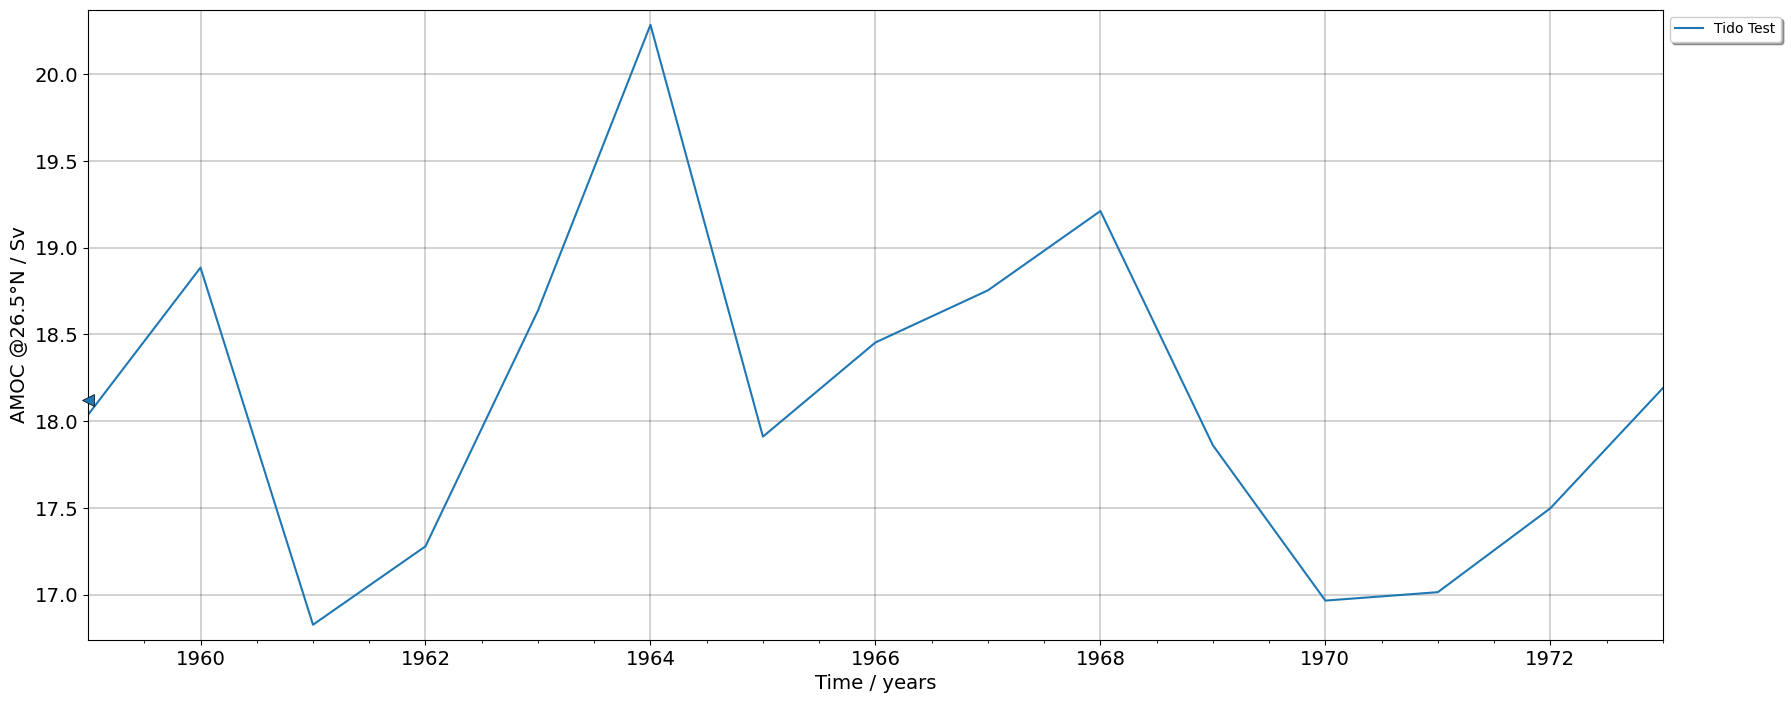

In [8]:
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
if do_ucell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['zmoc_nadw','zmoc_ucell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>30) & (data.lat<50)).max(dim='lat') 
                        str_label= f'@{30}°N<lat<{50}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc_t_ucell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
   
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                do_enum    = do_enum                 ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )            

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
if do_lcell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['zmoc_aabw','zmoc_lcell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>-20) & (data.lat<60)).min(dim='lat') 
                        str_label= f'@{-20}°S<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    data_lat[var].attrs['short_name'] = 'AABW'
                    data_lat[var].attrs['long_name']  = 'AABW'
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc_t_lcell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
        
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                grid_opt   = dict({'do_yinvert':True}),
                                do_enum    = do_enum                  ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()